## Example: Sparse inverse covariance selection via ADMM
https://web.stanford.edu/~boyd/papers/admm/covsel/covsel.html
https://web.stanford.edu/~boyd/papers/admm/covsel/covsel_example.html

objective
$$
\text{minimize } tr(SX) - log det X + \lambda \|x\|_1
$$

In [1]:
import numpy as np
import scipy as sp
import numpy.linalg as npl
import scipy.linalg as spl
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

# default globals
MAX_ITER = 1000
ABSTOL = 1e-4
RELTOL = 1e-2

In [2]:
# generate data
np.random.seed(1)
M = 100 # num features
N = 10*M # num samples

# positive definite inverse covariance matrix
Sinv = np.diag(np.ones(M)) # MxM covinv
idx = np.random.choice(M, size=int(0.001*M**2), replace=False)
Sinv.flat[idx] = np.ones(idx.shape[0])

Sinv = Sinv + Sinv.T # make symmetric
eig, _ = npl.eig(Sinv)
if np.min(eig) < 0:
    Sinv += 1.1*np.abs(np.min(eig))*np.eye(M) # make PD

S0 = npl.inv(Sinv)

# generate gaussian samples
D = np.random.multivariate_normal(np.zeros(M), S0, N) # NxM

rho = 1.0
alpha = 1.0
lam = 0.01

In [3]:
def objective(S, X, Z, lam):
    return np.trace(S@X) - np.log(npl.det(X)) + lam*npl.norm(Z, ord=1)

def shrinkage(x, kappa):
    q1 = x - kappa
    q1[q1<0] = 0
    q2 = -x - kappa 
    q2[q2<0] = 0
    return q1 - q2

In [4]:
def covsel(D, lam, rho, alpha):
    '''
    Solve sparse inverse covsel via ADMM:
        minimize tr(SX) - logdet(X) + \lambda ||x||_1

        S - emprical covariance
        D - data matrix
        hist - logs objective value, primal/dual residual norms, primal/dual tolerances
        rho - augmented Lagrangian param
        alpha - over-relaxation param
    '''
    S = np.cov(D, rowvar=False) # NxN
    N = S.shape[0]

    X = np.zeros(M)
    Z = np.zeros(M)
    U = np.zeros(M)

    hist = {}
    hist['objval'] = []
    hist['r_norm'] = []
    hist['s_norm'] = []
    hist['eps_pri'] = []
    hist['eps_dual'] = []

    for k in range(MAX_ITER):
        # X-update
        L, Q = npl.eig(rho*(Z - U) - S)
        xi = (L + np.sqrt(L**2 + 4*rho))/(2*rho) # see notes p.4
        X = Q@np.diag(xi)@Q.T

        # Z-update
        Zprev = Z
        Xhat = alpha*X + (1 - alpha)*Zprev
        Z = shrinkage(Xhat + U, lam/rho)

        U = U + (Xhat - Z)

        # bookkeeping
        hist['objval'] += [objective(S, X, Z, lam)]
        hist['r_norm'] += [npl.norm(X - Z)]
        hist['s_norm'] += [npl.norm(-rho*(Z - Zprev))]
        hist['eps_pri'] += [np.sqrt(M*M)*ABSTOL + RELTOL*max(npl.norm(X), npl.norm(Z))]
        hist['eps_dual'] += [np.sqrt(M*M)*ABSTOL + RELTOL*npl.norm(rho*U)]

        # termination condition
        if hist['r_norm'][k] < hist['eps_pri'][k] and hist['s_norm'][k] < hist['eps_dual'][k]:
                break

        return X, hist

In [5]:
X, hist = covsel(D, lam, rho, alpha)

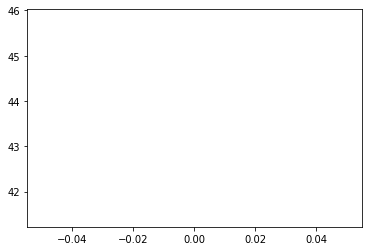

In [6]:
K = len(hist['objval'])
plt.plot(hist['objval'])

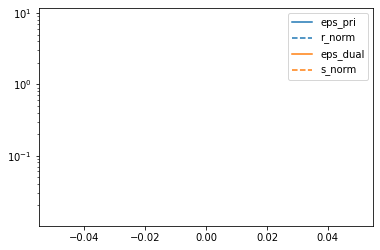

In [7]:
plt.plot(hist['eps_pri'], 'C0-', label='eps_pri')
plt.plot(hist['r_norm'], 'C0--', label='r_norm')
plt.plot(hist['eps_dual'], 'C1-', label='eps_dual')
plt.plot(hist['s_norm'], 'C1--', label='s_norm')
plt.yscale('log')
plt.legend()

In [8]:
print("iter\tr_norm\t\teps_pri\t\ts_norm\t\teps_dual")
for k in range(K):
    print("%d\t%.4f\t\t%.4f\t\t%.4f\t\t%.4f"
          %(k, hist['r_norm'][k], hist['eps_pri'][k], hist['s_norm'][k], hist['eps_dual'][k]))

iter	r_norm		eps_pri		s_norm		eps_dual
0	0.4232		0.0958		8.4605		0.0142
